In [1]:
# 0) Imports & settings
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings("ignore")
from pathlib import Path

# sklearn
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

RND = 42


In [2]:
# 1) Unzip the dataset & Load CSVs

import zipfile
import os
import pandas as pd

# Path to your zip file
zip_path = r"C:\Users\rifat\Downloads\Compressed\archive_5.zip"
extract_dir = r"C:\Users\rifat\Downloads\Compressed\crm_sales_dataset"

# Unzip only if not already extracted
if not os.path.exists(extract_dir):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print("✅ Files extracted to:", extract_dir)
else:
    print("⚡ Already extracted at:", extract_dir)

# Load datasets
accounts = pd.read_csv(os.path.join(extract_dir, "accounts.csv"))
products = pd.read_csv(os.path.join(extract_dir, "products.csv"))
sales_pipeline = pd.read_csv(os.path.join(extract_dir, "sales_pipeline.csv"))
sales_teams = pd.read_csv(os.path.join(extract_dir, "sales_teams.csv"))

print("Loaded shapes:")
print(" accounts:", accounts.shape)
print(" products:", products.shape)
print(" sales_pipeline:", sales_pipeline.shape)
print(" sales_teams:", sales_teams.shape)


⚡ Already extracted at: C:\Users\rifat\Downloads\Compressed\crm_sales_dataset
Loaded shapes:
 accounts: (85, 7)
 products: (7, 3)
 sales_pipeline: (8800, 8)
 sales_teams: (35, 3)


In [3]:
# 2) Merge datasets into master dataframe
df = sales_pipeline.merge(accounts, on="account", how="left") \
                   .merge(products, on="product", how="left") \
                   .merge(sales_teams, on="sales_agent", how="left")

print("Master shape:", df.shape)
display(df.head())


Master shape: (8800, 18)


,opportunity_id,sales_agent,product,account,deal_stage,engage_date,close_date,close_value,sector,year_established,revenue,employees,office_location,subsidiary_of,series,sales_price,manager,regional_office
0,1C1I7A6R,Moses Frase,GTX Plus Basic,Cancity,Won,2016-10-20,2017-03-01,1054.0,retail,2001.0,718.62,2448.0,United States,NaN,GTX,1096.0,Dustin Brinkmann,Central
1,Z063OYW0,Darcel Schlecht,GTXPro,Isdom,Won,2016-10-25,2017-03-11,4514.0,medical,2002.0,3178.24,4540.0,United States,NaN,NaN,NaN,Melvin Marxen,Central
2,EC4QE1BX,Darcel Schlecht,MG Special,Cancity,Won,2016-10-25,2017-03-07,50.0,retail,2001.0,718.62,2448.0,United States,NaN,MG,55.0,Melvin Marxen,Central
3,MV1LWRNH,Moses Frase,GTX Basic,Codehow,Won,2016-10-25,2017-03-09,588.0,software,1998.0,2714.90,2641.0,United States,Acme Corporation,GTX,550.0,Dustin Brinkmann,Central
4,PE84CX4O,Zane Levy,GTX Basic,Hatfan,Won,2016-10-25,2017-03-02,517.0,services,1982.0,792.46,1299.0,United States,NaN,GTX,550.0,Summer Sewald,West


In [4]:
# 3) Create binary target: Won=1, Lost=0
df['deal_stage'] = df['deal_stage'].astype(str).str.strip()
mask = df['deal_stage'].isin(['Won', 'Lost'])
df = df.loc[mask].reset_index(drop=True)
df['target_win'] = df['deal_stage'].map({'Lost':0, 'Won':1})

print("Filtered shape:", df.shape)
print(df['target_win'].value_counts())


Filtered shape: (6711, 19)
target_win
1    4238
0    2473
Name: count, dtype: int64


In [5]:
# 4) Feature engineering
df['engage_date'] = pd.to_datetime(df['engage_date'], errors='coerce')
df['close_date']  = pd.to_datetime(df['close_date'], errors='coerce')
df['days_to_close'] = (df['close_date'] - df['engage_date']).dt.days
df['engage_year'] = df['engage_date'].dt.year
df['engage_month'] = df['engage_date'].dt.month
df['engage_quarter'] = df['engage_date'].dt.quarter
df['engage_dow'] = df['engage_date'].dt.dayofweek

# Account age
if 'year_established' in df.columns:
    df['account_age'] = (pd.Timestamp.now().year - pd.to_numeric(df['year_established'], errors='coerce')).fillna(0)

# Log transform skewed numeric features
for col in ['revenue','sales_price','close_value','employees']:
    if col in df.columns:
        df[col+'_log1p'] = np.log1p(pd.to_numeric(df[col], errors='coerce').fillna(0))


In [6]:
# 5) Prepare X and y
drop_cols = ['opportunity_id','account','sales_agent','engage_date','close_date','deal_stage','target_win']
X = df.drop(columns=drop_cols, errors='ignore')
y = df['target_win'].astype(int)

print("Feature shape:", X.shape)
display(X.head())


Feature shape: (6711, 22)


,product,close_value,sector,year_established,revenue,employees,office_location,subsidiary_of,series,sales_price,...,days_to_close,engage_year,engage_month,engage_quarter,engage_dow,account_age,revenue_log1p,sales_price_log1p,close_value_log1p,employees_log1p
0,GTX Plus Basic,1054.0,retail,2001.0,718.62,2448.0,United States,NaN,GTX,1096.0,...,132,2016,10,4,3,24.0,6.578723,7.000334,6.961296,7.803435
1,GTXPro,4514.0,medical,2002.0,3178.24,4540.0,United States,NaN,NaN,NaN,...,137,2016,10,4,1,23.0,8.064397,0.000000,8.415160,8.420903
2,MG Special,50.0,retail,2001.0,718.62,2448.0,United States,NaN,MG,55.0,...,133,2016,10,4,1,24.0,6.578723,4.025352,3.931826,7.803435
3,GTX Basic,588.0,software,1998.0,2714.90,2641.0,United States,Acme Corporation,GTX,550.0,...,135,2016,10,4,1,27.0,7.906879,6.311735,6.378426,7.879291
4,GTX Basic,517.0,services,1982.0,792.46,1299.0,United States,NaN,GTX,550.0,...,128,2016,10,4,1,43.0,6.676403,6.311735,6.249975,7.170120


In [7]:
# 6) Identify numeric & categorical columns
numeric_cols = X.select_dtypes(include=['number']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Remove original revenue, sales_price, employees if using log version
for orig, log in [('revenue','revenue_log1p'),('sales_price','sales_price_log1p'),('employees','employees_log1p')]:
    if orig in numeric_cols and log in X.columns:
        numeric_cols.remove(orig)

print("Numeric cols:", numeric_cols)
print("Categorical cols:", categorical_cols)


Numeric cols: ['close_value', 'year_established', 'days_to_close', 'engage_year', 'engage_month', 'engage_quarter', 'engage_dow', 'account_age', 'revenue_log1p', 'sales_price_log1p', 'close_value_log1p', 'employees_log1p']
Categorical cols: ['product', 'sector', 'office_location', 'subsidiary_of', 'series', 'manager', 'regional_office']


In [10]:
# 7) Preprocessing pipelines (fixed for scikit-learn >=1.2)
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # <-- changed here
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])


In [11]:
# 8) Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RND, stratify=y)
print("Train/Test shapes:", X_train.shape, X_test.shape)


Train/Test shapes: (5368, 22) (1343, 22)


In [12]:
# 9) Baseline RandomForest pipeline
rf_pipe = Pipeline([
    ('preproc', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=RND, n_jobs=-1))
])
rf_pipe.fit(X_train, y_train)

# Evaluation function
def evaluate(model, X_t, y_t, name="model"):
    y_pred = model.predict(X_t)
    y_proba = model.predict_proba(X_t)[:,1]
    print(f"--- {name} ---")
    print(classification_report(y_t, y_pred, digits=4))
    print("Confusion matrix:\n", confusion_matrix(y_t, y_pred))
    print("ROC-AUC:", round(roc_auc_score(y_t, y_proba),4))

evaluate(rf_pipe, X_test, y_test, "Baseline RandomForest")


--- Baseline RandomForest ---
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       495
           1     1.0000    1.0000    1.0000       848

    accuracy                         1.0000      1343
   macro avg     1.0000    1.0000    1.0000      1343
weighted avg     1.0000    1.0000    1.0000      1343

Confusion matrix:
 [[495   0]
 [  0 848]]
ROC-AUC: 1.0


,feature,importance
0,close_value,0.508236
10,close_value_log1p,0.438736
2,days_to_close,0.011368
4,engage_month,0.005779
6,engage_dow,0.003704
11,employees_log1p,0.002624
8,revenue_log1p,0.002548
7,account_age,0.002517
1,year_established,0.002383
3,engage_year,0.002272


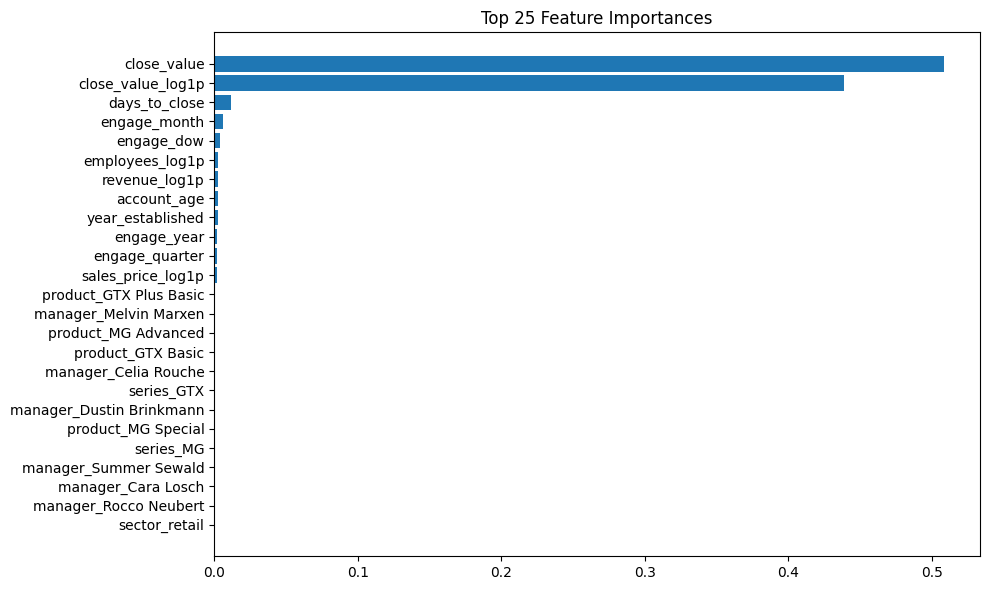

In [13]:
# 10) Feature importance
clf = rf_pipe.named_steps['clf']
pre = rf_pipe.named_steps['preproc']

# Get column names after OHE
def get_feature_names(preprocessor, numeric_cols, categorical_cols):
    cat_transformer = preprocessor.named_transformers_['cat'].named_steps['ohe']
    cat_names = cat_transformer.get_feature_names_out(categorical_cols)
    return numeric_cols + list(cat_names)

feat_names = get_feature_names(pre, numeric_cols, categorical_cols)
importances = clf.feature_importances_

fi = pd.DataFrame({'feature':feat_names,'importance':importances}).sort_values('importance',ascending=False).head(25)
display(fi)

plt.figure(figsize=(10,6))
plt.barh(fi['feature'][::-1], fi['importance'][::-1])
plt.title("Top 25 Feature Importances")
plt.tight_layout()
plt.show()


In [14]:
# 11) Save the model
joblib.dump(rf_pipe, os.path.join(extract_dir, "win_probability_rf.joblib"))
print("Saved model at:", os.path.join(extract_dir, "win_probability_rf.joblib"))


Saved model at: C:\Users\rifat\Downloads\Compressed\crm_sales_dataset\win_probability_rf.joblib
